# Финальный проект

## Общее описание:
### Задание 1. A/B–тестирование

1. Условие

Одной из основных задач аналитикака в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

2. Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

 - `groups.csv` - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
 - `groups_add.csv` - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
 - `active_studs.csv` - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
 - `checks.csv` - файл с информацией об оплатах пользователей в дни проведения эксперимента
 
3. Вопросы

 - На какие метрики Вы смотрите в ходе анализа и почему?
 - Имеются ли различия в показателях и с чем они могут быть связаны?
 - Являются ли эти различия статистически значимыми?
 - Стоит ли запускать новую механику на всех пользователей?
 

4. План

 - Посмотреть данные, сделать разведывательный анализ данных
 - Построить графики, посмотреть форму распределения величин
 - Определить метрики, на которые будем опираться
 - Выбрать гипотезу, выбрать подходящий тест 
 - Ответы на вопросы, сделать выводы

Импортируем библиотеки

In [6]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize': (16, 5)})
colors = ["#69b3a2", "#4374B3"]
sns.set_palette(sns.color_palette(colors))

from tqdm.auto import tqdm
import pingouin as pg

from urllib.parse import urlencode
import requests

### Разведывательный анализ данных

Убедимся, что данные считываются

In [7]:
# Используем API
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
url_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
url_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
url_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
url_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'

# Получаем URL
visits_url_groups = base_url + urlencode(dict(public_key=url_groups))
visits_url_groups_add = base_url + urlencode(dict(public_key=url_groups_add))
visits_url_checks = base_url + urlencode(dict(public_key=url_checks))
visits_url_active_studs = base_url + urlencode(dict(public_key=url_active_studs))
    
response_1 = requests.get(visits_url_groups) 
download_url_1 = response_1.json()['href'] 
    
response_2 = requests.get(visits_url_groups_add) 
download_url_2 = response_2.json()['href'] 

response_3 = requests.get(visits_url_checks) 
download_url_3 = response_3.json()['href'] 
    
response_4 = requests.get(visits_url_active_studs) 
download_url_4 = response_4.json()['href'] 
    
groups = pd.read_csv(download_url_1, sep=';')
group_add = pd.read_csv(download_url_2)
checks = pd.read_csv(download_url_3, sep=';')
active_studs = pd.read_csv(download_url_4)

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [8]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [9]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [10]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [11]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


Данные считываются. Далее изучим данные: определим размеры датасетов, наличие пропусков, дублей, посмотрим типы данных, количество уникальных значений.

In [12]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [13]:
groups.duplicated().sum()

0

In [14]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [15]:
groups.id.nunique()

74484

In [16]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [17]:
group_add.isna().sum()

id     0
grp    0
dtype: int64

In [18]:
group_add.duplicated().sum()

0

In [19]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [20]:
checks.student_id.nunique()

541

In [21]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [22]:
checks.duplicated().sum()

0

In [23]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [24]:
active_studs.isna().sum()

student_id    0
dtype: int64

In [25]:
active_studs.duplicated().sum()

0

Пропусков нет, дублей нет, данные в нужном формате, приступим к объединению таблиц. Переименуем в двух таблицах столбец `student_id` в`id`. Убедимся, что объединение прошло корректно (посмотрим на размеры результирующих датасетов).

In [26]:
all_students = groups.merge(group_add, how='outer', on=['id', 'grp'])
all_students.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [27]:
all_students.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [28]:
all_students.isna().sum()

id     0
grp    0
dtype: int64

In [29]:
all_students.duplicated().sum()

0

Добавляем колонку "be_on_platform" с значением 1 - пользьователи, которые были на платформе во время АБ теста.

In [30]:
active_studs = active_studs.rename(columns={'student_id': 'id'})
active_studs.insert(loc=1, column='be_on_platform', value=1)
active_studs.head()

,id,be_on_platform
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


In [31]:
checks = checks.rename(columns={'student_id': 'id'})
checks.head()

,id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [32]:
all_students_ab = all_students.merge(active_studs, how='outer', on='id')

Заполним все пустые ячейки значением 0 (пользователи, которые не были на платформе в дни А/В теста)

In [33]:
all_students_ab['be_on_platform'] = all_students_ab['be_on_platform'].fillna(0) 

all_students_ab = all_students_ab.merge(checks, how='outer', on='id')
all_students_ab.rev = all_students_ab.rev.fillna(0)
all_students_ab.head()

,id,grp,be_on_platform,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


In [34]:
all_students_ab.isna().sum()

id                0
grp               0
be_on_platform    0
rev               0
dtype: int64

In [35]:
all_students_ab.duplicated().sum()

0

Объединение прошло корректно (количество пользователей соответствует сумме пользователей из исходной и дополнительной таблиц), пропусков и дублей нет.

Изучим результирующую таблицу `all_students_ab`, в которой собрана вся информация обо всех пользователях, об их покупках и участии в А/В тесте.

In [36]:
all_students_ab.query('be_on_platform == 0 and rev!= 0').shape[0] 

149

Видим, что есть часть пользователей (149), которые не были на платформе в дни проведения А/В теста, однако совершали покупки в дни эксперимента. Возможно, это ошибка в данных, а возможно - автоплатеж. В любом случае, мы их отфильтруем и не будем учитывать в дальнейшем исследовании.

Посмотрим на пользователей, которые были на платформе в дни эксперимента.

In [37]:
be_on_platform = all_students_ab.query('be_on_platform == 1')
be_on_platform.nunique()

id                8341
grp                  2
be_on_platform       1
rev                 39
dtype: int64

In [38]:
be_on_platform.head()

,id,grp,be_on_platform,rev
1,1627,A,1.0,990.0
10,2085,B,1.0,0.0
12,2215,B,1.0,0.0
43,3391,A,1.0,0.0
45,3401,B,1.0,0.0


### Расчет стат. величин, изучение распределения величин, построение графиков

Изучим основные статистические величины для значений из колонки `rev` таблицы `be_on_platform`. Можно увидеть из таблицы и из графика `boxplot`, что большая чать аудитории в обеих группах не покупали (значение `rev` равно 0).

In [39]:
stat_describe_be_on_platform = be_on_platform.groupby('grp').rev.describe().reset_index()
stat_describe_be_on_platform

,grp,count,mean,std,min,25%,50%,75%,max
0,A,1538.0,47.347204,290.490632,0.0,0.0,0.0,0.0,3660.0
1,B,6803.0,58.058798,313.770201,0.0,0.0,0.0,0.0,4650.0


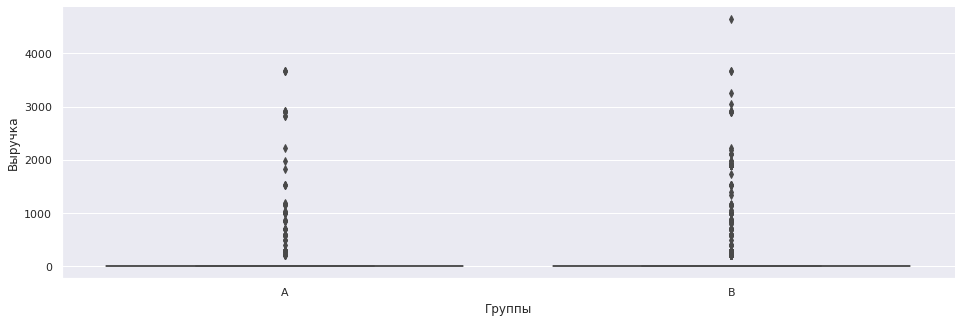

In [40]:
ax = sns.boxplot(x='grp', y='rev', data=be_on_platform)
ax.set(xlabel='Группы', ylabel='Выручка')
sns.despine()

Попробуем отфильтровать тех пользователей, которые платили в обеих группах (то есть клиентов), и посмотрим, как распределены значения и также получим основные стат. величины.

In [41]:
students_rev = be_on_platform.query('rev != 0')
students_rev.head()

,id,grp,be_on_platform,rev
1,1627,A,1.0,990.0000
220,100300,B,1.0,990.0000
320,108270,B,1.0,290.0000
3779,264473,B,1.0,1900.0001
4187,274352,B,1.0,690.0000


In [42]:
stat_describe_stud_rev = students_rev.groupby('grp').rev.describe().reset_index()
stat_describe_stud_rev

,grp,count,mean,std,min,25%,50%,75%,max
0,A,78.0,933.589744,919.932711,199.0,290.00,585.0,1114.75,3660.0
1,B,314.0,1257.878992,790.864254,199.0,511.75,1140.0,1900.00,4650.0


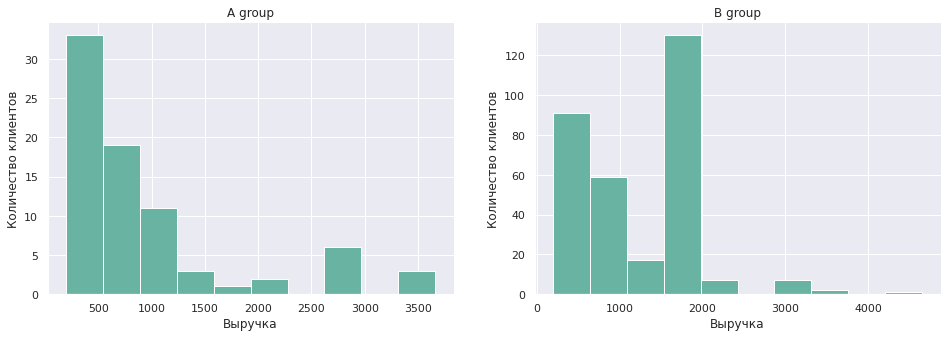

In [43]:
students_rev_a = students_rev.query('grp == "A"')
students_rev_b = students_rev.query('grp == "B"')
fig, axs = plt.subplots(1, 2)
axs[0].hist(students_rev_a['rev'], linewidth=1, edgecolor="white")
axs[0].set_title('A group')
axs[0].set(xlabel='Выручка', ylabel='Количество клиентов')
axs[1].hist(students_rev_b['rev'], linewidth=1, edgecolor="white")
axs[1].set_title('B group')
axs[1].set(xlabel='Выручка', ylabel='Количество клиентов')
sns.despine()
plt.show()

Для клиентов (кто платил) наблюдаем уже другую ситуацию, видим что значения колонки `rev` различаются в широком диапазоне, причем в группе В - диапазон шире, возможно добавили какие-то новые продукты (курсы). Другое объяснение - так как выборка в группе В более, чем в 4 раза больше, чем в группе А, такой разброс значений `rev` можно объяснить лучшей репрезентативностью группы В.

Так как метрика `rev` - количественная, мы попробуем проверить, нормально ли распределены значения данной колонки, как в датасете со всеми пользователями, так и с клиентами, кто платил, с использованием теста Шапиро-Уилка (но по графикам, мы уже предполагаем, что распределение ненормальное).

In [44]:
pg.normality(data=students_rev, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,30.378420,2.531687e-07,False
B,6.795663,3.344572e-02,False


In [45]:
pg.normality(data=be_on_platform, dv="rev", group="grp", method="normaltest")

,W,pval,normal
A,2240.595797,0.0,False
B,7797.399212,0.0,False


Тест Шапиро-Уилка подтвердил ненормальное распределение, так как во всех случаях Р-value << 0.05.
Однако для проверки гипотез мы это учитывать не будем (не так важно нормальное распределение в выборках, как нормальное распределение выборочных средних, которое можно проверить, используя бутстреп). Попробуем также проверить гомогенность дисперсий в группах, чтобы окончательно понять, можем ли мы воспользоваться t-тестом (он же критерий Стьюдента) для сравнения средних значений в группах.

In [46]:
pg.homoscedasticity(data=students_rev[students_rev.rev > 0], dv='rev', group='grp')

,W,pval,equal_var
levene,3.075682,0.080257,True


In [47]:
pg.homoscedasticity(data=be_on_platform[be_on_platform.rev > 0], dv='rev', group='grp')

,W,pval,equal_var
levene,3.075682,0.080257,True


Получается, что тест на гомоскедастичность пройден (True), и дисперсии в выборках равны, значит, в целом, применить t-тест можно, в случае, если не будет выбросов (проверим далее).

Далее построим график `countplot` и посмотрим, сколько людей (в обеих группах А и Б) совершали покупки по той или иной цене.

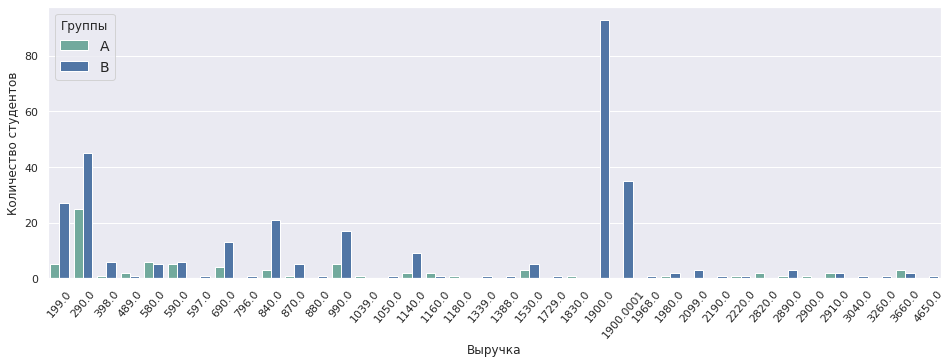

In [48]:
ax = sns.countplot(data=students_rev, x='rev', hue='grp')
ax.set(xlabel='Выручка', ylabel='Количество студентов')
ax.legend(fontsize=14, title='Группы')
plt.xticks(rotation=50)
plt.show()

Из графика видно, что в ценовом диапазоне, близком к 2000, совершалось больше всего покупок, причем для группы Б, на втором месте в ценовой категории от 200 до 300 условных единиц. Так, можно предположить, что либо новая механика оплаты позволила улучшить показатели, или есть какая-то ошибка в сборе данных (ошибка в сплитовании), ведь количество клиентов в группе Б в ~4 раза больше, чем в группе А.

### Выбор метрик, формулировка предположения, которое будем тестировать

Далее приведен набор метрик, который потенциально можно было бы попробовать сравнить для двух групп А/В теста, чтобы ответить на вопрос, стоит ли запускать новую механику оплаты. Соответственно мы будем далее тестировать, значимо ли различаются данные метрики.

- CR (конверсия в покупку): CR = количество клиентов / число пользователей.
- ARPU (средний доход с привлечённого пользователя): ARPU = доход / число пользователей.
- ARPPU (Средний доход на платящего пользователя, то есть клиента) - число повторных покупок * средний чек.
- Средний чек клиента: сумма всех чеков / количество клиентов.

Однако в нашем случае все клиенты покупали только 1 раз, поэтому для них ARPPU будет равен среднему чеку. 
Посчитаем все, кроме ARPPU.

In [49]:
a_gr_plat = be_on_platform.query('grp == "A"')
b_gr_plat = be_on_platform.query('grp == "B"')

In [50]:
cr_a_gr = (a_gr_plat[a_gr_plat.rev != 0].rev.count() / a_gr_plat.rev.count() * 100).round(2)
cr_b_gr = (b_gr_plat[b_gr_plat.rev != 0].rev.count() / b_gr_plat.rev.count() * 100).round(2)
arpu_a = (a_gr_plat.rev.sum() / a_gr_plat.id.nunique()).round(2)
arpu_b = (b_gr_plat.rev.sum() / b_gr_plat.id.nunique()).round(2)
mean_rev_a = a_gr_plat.query('rev!=0').rev.mean().round(2)
mean_rev_b = b_gr_plat.query('rev!=0').rev.mean().round(2)

Создадим датафрейм со всеми метриками

In [51]:
df = pd.DataFrame({'group': ['A', 'B'],
                   'count_students': [stat_describe_be_on_platform['count'][0],
                                      stat_describe_be_on_platform['count'][1]],
                   'count_clients': [stat_describe_stud_rev['count'][0],
                                     stat_describe_stud_rev['count'][1]],
                   'CR%': [cr_a_gr, cr_b_gr],
                   'ARPU': [arpu_a, arpu_b],
                   'mean_rev': [mean_rev_a, mean_rev_b]})
df

,group,count_students,count_clients,CR%,ARPU,mean_rev
0,A,1538.0,78.0,5.07,47.35,933.59
1,B,6803.0,314.0,4.62,58.06,1257.88


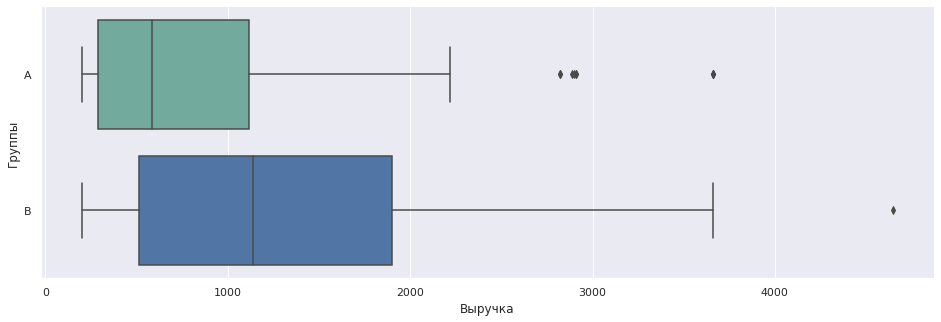

In [52]:
ax = sns.boxplot(x='rev', y='grp', data=students_rev)
ax.set(xlabel='Выручка', ylabel='Группы')
sns.despine()

Для наглядности приведен график `boxplot`, на котором можно увидеть разброс значений и медиану для значений колонки `rev` для пользователей (кто совершал покупки). Здесь мы видим, что есть выбросы, а медиана в группе В - больше, чем в группе А. Однако, мы будем считать, что выбросов в наших выборках нет, и все значения являются достоверными.

Как мы можем увидеть из таблицы, конверсия в покупку уменьшилась, однако другие две метрики увеличились, нужно будет проверить, стат.значимы ли эти изменения. 

### Выбор критериев и проведение А/В-тестов

Для выбора критериев необходимо посмотреть на наши метрики и их тип. Итак, у нас есть метрика - средний чек (`mean_rev`) - количественная метрика. Ранее было показано, что значения `rev` распределены ненормально, но пришли к выводу, что это не будет влиять на выбор метрик. 

Также обратим внимание на выборки для А/В тестов, количество пользователей в обеих группах сильно различается, причем в группе В пользователей больше в несколько раз. Это странно, обычно в группе В количество пользователей должно быть меньше, чтобы минимизировать риски в бизнесе. Возможно система сплитования работает некорректно. Однако размер выборок (>30) не ограничивает нас в выборе метода анализа.

В качестве метрики мы можем для начала потестировать значения среднего чека, как для всех пользователей, так и только для тех, которые совершали покупки. Для этого потенциально можно было бы использовать t‑тест Стьюдента, U-критерий Манна-Уитни и бутстреп. 

В отличие от параметрических тестов, таких как t‑тест Стьюдента (и др.), непараметрический U‑test Манна‑Уитни не делает никаких предположений о форме базового распределения, но проверяет равенства распределений. Его применяют в случае, когда есть выбросы, так как он переводит значения в ранги. Однако, этот критерий очень сложно интерпретировать в бизнесе и получается, что он **не очень подходит** нам для сравнения средних или медиан.

Воспользуемся t‑тестом Стьюдента для оценки средних значений метрик.

In [53]:
pg.ttest(students_rev[students_rev.grp == 'A'].rev, students_rev[students_rev.grp == 'B'].rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.86169,106.981668,two-sided,0.00507,"[-548.94, -99.64]",0.39646,6.536,0.878211


Определим гипотезы: 
- **H0** - разницы в средних чеках клиентов (считаем по колонке `rev`) нет, 
- **Н1** - разница есть.

t‑тест Стьюдента показал p-value = 0.00507 < 0,05. Это говорит о том, что можно отвергнуть нулевую гипотезу. Различия в средних чеках есть в группе В по сравнению с группой А экспермента, но только для клиентов (кто совершал покупки). Как мы видели ранее на графике, различия действительно есть, это увеличение покупок в группе В на сумму ~2000. Но с чем это связано - неизвестно.

In [54]:
pg.ttest(a_gr_plat.rev, a_gr_plat.rev)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.0,3074,two-sided,1.0,"[-20.54, 20.54]",0.0,0.041,0.05


Аналогично, здесь гипотезы:
- **H0** - разницы в средних чеках всех пользователей (считаем по колонке `rev`) нет, 
- **Н1** - разница есть. 

P-value = 1, что больше 0,05. Это говорит о том, что нельзя отвергнуть нулевую гипотезу, различий в средних чеках нет для всех пользователей.

Попробуем применить Бутстрап анализ средних. Данный метод не требует нормальности распределения данных. Однако он лучше работает на маленьких выборках.

In [55]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = ss.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = ss.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

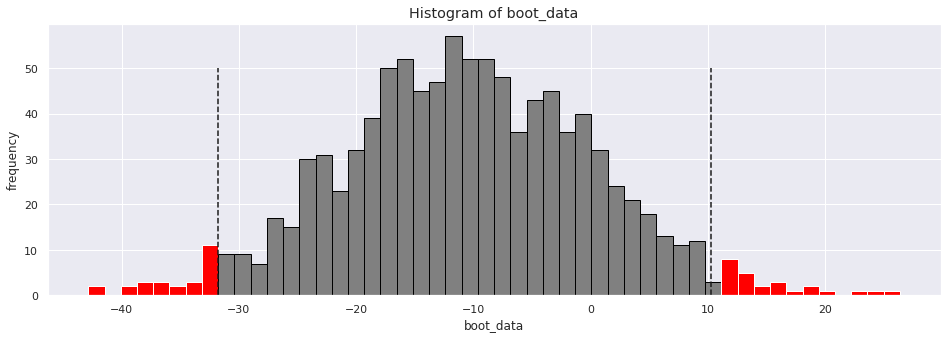

In [56]:
boot_data_students_all = get_bootstrap(a_gr_plat.rev,  # числовые значения первой выборки
                                       b_gr_plat.rev,  # числовые значения второй выборки
                                       boot_it=1000,  # количество бутстрэп-подвыборок
                                       statistic=np.mean,  # интересующая нас статистика
                                       bootstrap_conf_level=0.95)  # уровень значимости

In [57]:
boot_data_students_all["p_value"]  # р-уровень значимости

0.32641006564090513

In [58]:
boot_data_students_all["quants"]  # Доверительный интервал

,0
0.025,-31.781568
0.975,10.278023


Аналогично, как для предыдущего теста, гипотезы:
- **Н0** - нет различий в средних чеках всех пользователей,
- **Н1** - есть различия в средних чеках. 

Здесь мы анализируем средние чеки всех пользователей, и, как видно из рисунка, есть пересечения с 0, а p-value больше 0,05, что говорит о том, что мы не отклоняем нулевую гипотезу, различий в чеках нет для всех пользователей. Данный вывод согласуется с тестом Стьюдента.

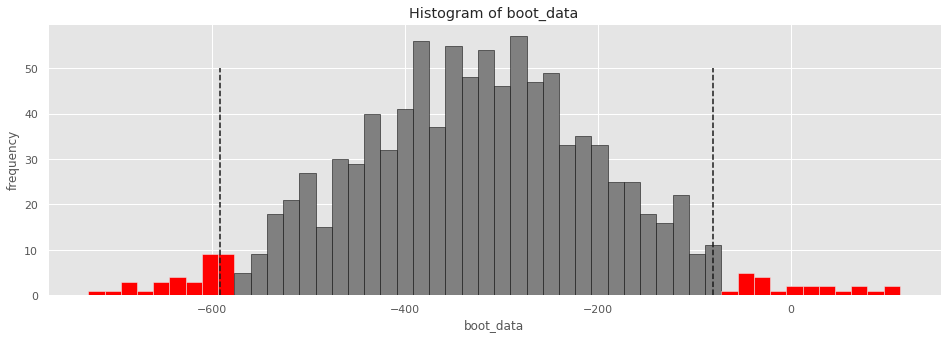

In [59]:
boot_data_students_rev = get_bootstrap(students_rev[students_rev.grp == 'A'].rev,  # числовые значения первой выборки
                                       students_rev[students_rev.grp == 'B'].rev,  # числовые значения второй выборки
                                       boot_it=1000,  # количество бутстрэп-подвыборок
                                       statistic=np.mean,  # интересующая нас статистика
                                       bootstrap_conf_level=0.95)  # уровень значимости

In [60]:
boot_data_students_rev["p_value"]  # р-уровень значимости

0.014601116354845142

In [61]:
boot_data_students_rev["quants"]  # Доверительный интервал

,0
0.025,-592.123412
0.975,-80.950649


Здесь мы анализируем средние чеки только для платящих клиентов.

Аналогично, как для предыдущего теста, гипотезы:
- **Н0** - нет различий в средних чеках клиентов,
- **Н1** - есть различия в средних чеках. 

Как видно из рисунка, нет пересечения с 0, а p-value меньше 0,05. Это говорит о том, что мы отклоняем нулевую гипотезу, а различя в чеках есть в группе В по сравнению с группой А для платящих клиентов. Данный вывод согласуется с тестом Стьюдента. 

In [62]:
df  # Результирующий датафрейм

,group,count_students,count_clients,CR%,ARPU,mean_rev
0,A,1538.0,78.0,5.07,47.35,933.59
1,B,6803.0,314.0,4.62,58.06,1257.88


Далее обратим внимаение на метрику CR. Наилучший метод, чтобы проверить статистическую значимость изменения для пропорций (а CR - пророрция, то есть качественная метрика) - это метод Хи‑Квадрат (критерий согласия Пирсона). Здесь мы анализируем число положительных событий относительно всех событий (число клиентов, кто совершил покупку, относительно всех пользователей, кто был на платформе в дни эксперимента, что является как раз конверсией или CR. Данный критерий подходит, для таблицы сопряженности любого размера, где значения ожидаемых и наблюдаемых частот в каждой ячейке больше 10 (наш случай).

Гипотезы:
- **H0** - новая механика оплаты не повлияла на конверсию (CR),
- **H1** - новая механика оплаты повлияла на конверсию (CR).

Запишем данные в переменные для двух групп:
Первое значение - количество людей, совершивших покупку (клиентов); второе значение - разность между общим количеством пользователей и числом тех, кто совершил покупку (клиентов).

In [63]:
group_A = [df.count_clients[0], df.count_students[0] - df.count_clients[0]]
group_B = [df.count_clients[1], df.count_students[1] - df.count_clients[1]]

# Запустим тест
chi2, p, dof, ex = ss.chi2_contingency([group_A, group_B], correction=False)

# Выводим результаты
print("Хи-квадрат p-value: ", p)

# Проверяем есть ли изменение
if p < 0.05:
    print("Отклоняем нулевую гипотезу H0, принимаем альтернативную H1: новая механика повлияла на CR.")
else:
    print("Отклоняем альтернативную гипотезу H1, принимаем Н0: новая механика не повлияла на CR.")

Хи-квадрат p-value:  0.44547028437158964
Отклоняем альтернативную гипотезу H1, принимаем Н0: новая механика не повлияла на CR.


### Выводы
- Стоит ли запускать новую механику на всех пользователей?

Исходя из проведенных исследований, нельзя с точностью сказать, принимать ли новую систему оплаты или нет, все зависит от цели А/В теста. 

Если говорить о конверсии в покупку (CR) - то она упала, тем не менее, согласно тесту хи-квадрат - новая механика оплаты не повлияла на CR.

Однако ARPU и средняя выручка (именно для клиентов) выросли (средняя выручка для всех пользователей одинаковая и равна ~0), поэтому прежде, чем принимать новую механику оплаты, необходимо дополнительно уточнить у команды все недостающие данные (что стало причиной такого неравномерного сплитования, что обуславливало рост в группе "В" товаров на сумму, близкую к 2000)? 

По всей вероятности, мы видим рост средней выручки и рост других метрик или из-за неверного сплитования, либо ввиду того, что клиенты начали покупать товары на сумму ~2000, возможно здесь и сыграла роль новая система оплаты, однако я бы не стала сразу запускать новую механику на всех пользователях без дополнительных уточнений.

### Задание 2. SQL

    1. Очень усердные ученики.

1.1 Условие

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

1.2 Задача

Дана таблица `default.peas`:

Название атрибута|Тип атрибута|Смысловое значение
-----------------|-------------|------------------
st_id|int|ID ученика
timest|timestamp|Время решения карточки
correct|bool|Правильно ли решена горошина?
subject|text|Дисциплина, в которой находится горошина


Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.
- NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.

    2. Оптимизация воронки

2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2 Задача

Дана таблицы: `default.peas` (см. выше), `default.studs`:

Название атрибута|	Тип атрибута|	Смысловое значение
-----------------|-------------|------------------
st_id|	int|	 ID ученика
test_grp|	text	| Метка ученика в данном эксперименте

и `default.final_project_check`:

Название атрибута|	Тип атрибута|	Смысловое значение
-----------------|-------------|------------------
st_id	|int 	|ID ученика
sale_time|	timestamp|	Время покупки
money|	int|	Цена, по которой приобрели данный курс
subject|	text | Предмет

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (`subject = 'math'`) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.

Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

In [64]:
import pandahouse as ph

In [65]:
connection_default = {'host': 'скрыто',
                      'database': 'скрыто',
                      'user': 'скрыто', 
                      'password': 'скрыто'}

In [66]:
query = """
SELECT COUNT(DISTINCT st_id) AS active_students

FROM (
    SELECT st_id, COUNT(subject) AS number_sub
    FROM default.peas 
    WHERE correct = 1
    GROUP BY st_id
    HAVING number_sub >= 20
    )
"""
df_1 = ph.read_clickhouse(query, connection=connection_default)
print('Ответ на задачу 1.2. Количество очень усердных студентов - ', df_1.active_students[0], 'человек')

Ответ на задачу 1.2. Количество очень усердных студентов -  136 человек


In [67]:
query = """
        --a
WITH sum_students AS 
    (SELECT COUNT(DISTINCT st_id) AS all_students,test_grp  FROM default.studs GROUP BY test_grp),
        
        --b
    clients AS 
    (SELECT 
        COUNT(DISTINCT a.st_id) AS clients, 
        a.test_grp AS test_grp
        FROM default.studs AS a
        INNER JOIN default.final_project_check AS b
        USING(st_id)
        GROUP BY test_grp
        ),
        
        --c
    active_students AS 
    (SELECT COUNT(DISTINCT st_id) AS active_students,test_grp
    FROM (
        SELECT
            a.st_id AS st_id,
            b.test_grp AS test_grp
        FROM default.peas AS a
        INNER JOIN default.studs AS b
        USING st_id
        GROUP BY test_grp, st_id
        HAVING SUM(correct) > 10
        )
    GROUP BY test_grp),
    
        --d
    active_students_math AS
    (SELECT COUNT(DISTINCT st_id) AS active_students_math,test_grp
    FROM
        (
        SELECT
            a.st_id AS st_id,
            b.test_grp AS test_grp
            
        FROM default.peas AS a
        INNER JOIN default.studs AS b
        USING st_id
        WHERE subject = 'Math'
        GROUP BY test_grp, st_id
        HAVING SUM(correct) >= 2
        )
        GROUP BY test_grp),
    
        --e
    sum_money AS
    (SELECT 
        SUM(a.money) AS sum_money,
        b.test_grp
    FROM default.final_project_check AS a
    JOIN default.studs AS b
    USING (st_id)
    GROUP BY test_grp),
       
        --f
    active_clients AS
    (SELECT COUNT(DISTINCT st_id) AS active_clients, test_grp
    FROM (
        SELECT a.st_id, a.test_grp AS test_grp
        FROM (
            SELECT
                a.st_id AS st_id,
                b.test_grp AS test_grp
            FROM default.peas AS a
            LEFT JOIN default.studs AS b
            ON a.st_id = b.st_id
            GROUP BY test_grp, st_id
            HAVING SUM(a.correct) > 10
            ) AS a
        INNER JOIN default.final_project_check AS b
        USING (st_id)
        )
    GROUP BY test_grp),
    
        --g
    active_clients_math AS
    (SELECT COUNT(DISTINCT st_id) AS active_clients_math, test_grp
    FROM 
        (
        SELECT a.st_id AS st_id, a.test_grp AS test_grp
        FROM
            (
            SELECT
                a.st_id AS st_id,
                b.test_grp AS test_grp
            FROM default.peas AS a
            INNER JOIN default.studs AS b
            USING st_id
            WHERE subject = 'Math'
            GROUP BY test_grp, st_id
            HAVING SUM(correct) >= 2
            ) AS a
        INNER JOIN default.final_project_check AS b
        USING st_id
        WHERE b.subject = 'Math'
        GROUP BY test_grp, st_id
        )
    GROUP BY test_grp),

        --h
    money_active AS
    (SELECT 
       SUM(a.money) AS money_active,
       b.test_grp AS test_grp
    FROM default.final_project_check AS a
    JOIN default.studs AS b
    ON a.st_id = b.st_id
    JOIN (SELECT st_id, SUM(correct) AS correct
        FROM default.peas
        GROUP BY st_id
        HAVING correct >10 ) AS c
    ON a.st_id = c.st_id
    GROUP BY  b.test_grp)
    
    
SELECT
a.test_grp AS test_grp,
b.clients/a.all_students * 100 AS CR_percent,
f.active_clients/c.active_students * 100 AS CR_active_percent,
g.active_clients_math/d.active_students_math * 100 AS CR_active_math_percent,
e.sum_money/a.all_students AS ARPU,
h.money_active/c.active_students AS ARPAU

FROM sum_students AS a

LEFT JOIN clients AS b
ON a.test_grp = b.test_grp

LEFT JOIN active_students AS c
ON a.test_grp = c.test_grp

LEFT JOIN active_students_math AS d
ON a.test_grp = d.test_grp

LEFT JOIN sum_money AS e
ON a.test_grp = e.test_grp

LEFT JOIN active_clients AS f
ON a.test_grp = f.test_grp

LEFT JOIN active_clients_math AS g
ON a.test_grp = g.test_grp

LEFT JOIN money_active AS h
ON a.test_grp = h.test_grp

"""
df_2 = ph.read_clickhouse(query, connection=connection_default).round(2)
print('Ответ на задачу 2.2:')
df_2

Ответ на задачу 2.2:


,test_grp,CR_percent,CR_active_percent,CR_active_math_percent,ARPU,ARPAU
0,control,4.92,11.02,6.12,4540.98,10393.70
1,pilot,10.85,26.04,9.52,11508.47,29739.58


### Задание 3. Python
3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [68]:
def file_append_and_metrics_count(url_groups, url_groups_add, url_checks, url_active_studs):
    """
    Функция, которая получает данные через API, 
    загружает их в датасет и рассчитывает метрики: 
    количество всех пользователей, клиентов, CR, ARPU, 
    средний чек клиентов для групп А и Б. 
    В качестве аргументов функции выступают URL данных.
    """
    
    import pandas as pd
    from urllib.parse import urlencode
    import requests
        
    
    # Используем API
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    # Получаем URL
    visits_url_groups = base_url + urlencode(dict(public_key=url_groups))
    visits_url_groups_add = base_url + urlencode(dict(public_key=url_groups_add))
    visits_url_checks = base_url + urlencode(dict(public_key=url_checks))
    visits_url_active_studs = base_url + urlencode(dict(public_key=url_active_studs))
    
    response_1 = requests.get(visits_url_groups) 
    download_url_1 = response_1.json()['href'] 
    
    response_2 = requests.get(visits_url_groups_add) 
    download_url_2 = response_2.json()['href'] 
    
    response_3 = requests.get(visits_url_checks) 
    download_url_3 = response_3.json()['href'] 
    
    response_4 = requests.get(visits_url_active_studs) 
    download_url_4 = response_4.json()['href'] 
         
    # Загружаем файл в df 
      
    groups = pd.read_csv(download_url_1, sep=';')
    groups = groups.rename(columns={groups.columns[0]: 'id', groups.columns[1]: 'grp'})
    
    group_add = pd.read_csv(download_url_2)
    group_add = group_add.rename(columns={group_add.columns[0]: 'id', group_add.columns[1]: 'grp'})
    
    checks = pd.read_csv(download_url_3, sep=';')
    checks = checks.rename(columns={checks.columns[0]: 'id'})
    
    active_studs = pd.read_csv(download_url_4)
    active_studs = active_studs.rename(columns={active_studs.columns[0]: 'id'})
    
    # Объединим датафреймы, удалив дубликаты и пропуски
    all_students = groups.merge(group_add, how='outer', on=['id', 'grp']).drop_duplicates().dropna()
    
    # Добавляем колонку "be_on_platform" с значением 1 - это пользователи, которые были на платформе во время А/В теста
    active_studs.insert(loc=1, column='be_on_platform', value=1) 
    
    # Получаем обобщенную таблицу со всеми пользователями, кто был и кого не было в дни А/В теста
    all_students_ab = all_students.merge(active_studs, how='outer', on='id')
    
    # Заполним все пустые ячейки значением 0 (пользователи, которые не были на платформе в дни А/В теста)
    all_students_ab['be_on_platform'] = all_students_ab['be_on_platform'].fillna(0)
    all_students_ab = all_students_ab.merge(checks, how='outer', on='id')
    all_students_ab.rev = all_students_ab.rev.fillna(0)
    
    # Отфильтруем пользователей, которые были на платформе в дни эксперимента
    be_on_platform = all_students_ab.query('be_on_platform == 1')  # Все пользователи
    
    # Посчитаем основные стат.параметры для всех пользователей и для клиентов
    stat_describe_be_on_platform = be_on_platform.groupby('grp').rev.describe().reset_index() 
    
    students_rev = be_on_platform.query('rev != 0')  # Клиенты
    stat_describe_stud_rev = students_rev.groupby('grp').rev.describe().reset_index() 
    
    # Создадим датафреймы, которые содержат в себе только пользователей или клиентов отдельно для группы А и группы В
    a_gr_plat = be_on_platform.query('grp == "A"')
    b_gr_plat = be_on_platform.query('grp == "B"')
    
    # Рассчитаем метрики
    cr_a_gr = (a_gr_plat[a_gr_plat.rev != 0].rev.count() / a_gr_plat.rev.count() * 100).round(2)
    cr_b_gr = (b_gr_plat[b_gr_plat.rev != 0].rev.count() / b_gr_plat.rev.count() * 100).round(2)
    arpu_a = (a_gr_plat.rev.sum() / a_gr_plat.id.nunique()).round(2)
    arpu_b = (b_gr_plat.rev.sum() / b_gr_plat.id.nunique()).round(2)
    mean_rev_a = a_gr_plat.query('rev!=0').rev.mean().round(2)
    mean_rev_b = b_gr_plat.query('rev!=0').rev.mean().round(2)
    
    # Создадим результирующий датафрейм со всеми метриками
    df = pd.DataFrame({'group': ['A', 'B'],
                       'count_students': [stat_describe_be_on_platform['count'][0],
                                          stat_describe_be_on_platform['count'][1]],
                       'count_clients': [stat_describe_stud_rev['count'][0],
                                         stat_describe_stud_rev['count'][1]],
                       'CR%': [cr_a_gr, cr_b_gr],
                       'ARPU': [arpu_a, arpu_b],
                       'mean_rev_clients': [mean_rev_a, mean_rev_b]})
    
    return df

In [69]:
url_groups_add = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
url_groups = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
url_checks = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'
url_active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'

In [70]:
metrics_df = file_append_and_metrics_count(url_groups, url_groups_add, url_checks, url_active_studs)
metrics_df

,group,count_students,count_clients,CR%,ARPU,mean_rev_clients
0,A,1538.0,78.0,5.07,47.35,933.59
1,B,6803.0,314.0,4.62,58.06,1257.88


In [71]:
def draw_plot(metrics):
    """
    Функция, которая по полученным метрикам:
    количество всех пользователей, клиентов, CR, ARPU, 
    средний чек клиентов для групп А и Б, и строит графики - barplot.
    """
    colors = ["#69b3a2", "#4374B3"]
    sns.set_palette(sns.color_palette(colors))

    # Set up the matplotlib figure
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)

    # Set the figure size
    plt.figure(figsize=(5, 6))

    sns.barplot(x='group', y='count_students', data=metrics, ax=ax1)
    ax1.set(xlabel='', ylabel='', title='Count students')

    sns.barplot(x='group', y='count_clients', data=metrics, ax=ax2)
    ax2.set(xlabel='', ylabel='', title='Сount clients')

    sns.barplot(x='group', y='CR%', data=metrics, ax=ax3)
    ax3.set(xlabel='', ylabel='', title='CR, %')

    sns.barplot(x='group', y='ARPU', data=metrics, ax=ax4)
    ax4.set(xlabel='', ylabel='', title='ARPU')

    sns.barplot(x='group', y='mean_rev_clients', data=metrics, ax=ax5)
    ax5.set(xlabel='', ylabel='', title='Mean revenue (clients)')


    sns.despine()
    plt.show()
    
    return

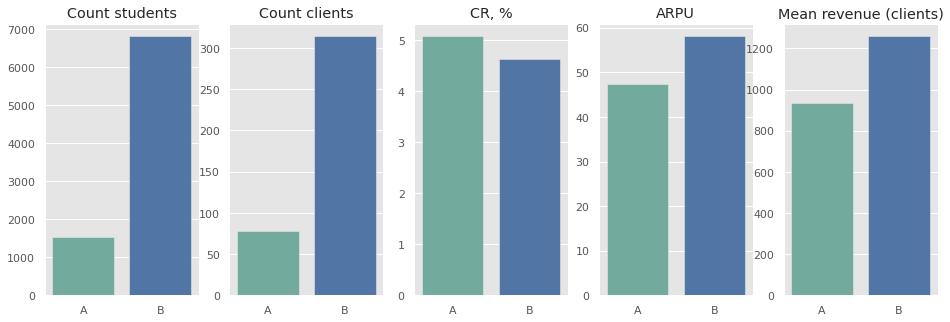

<Figure size 360x432 with 0 Axes>

In [72]:
draw_plot(metrics_df)